In [2]:
inpath = '/dls/science/groups/das/ExampleData/hdfmap_tests/i06/i06-1-353226.nxs'
inpath = "/dls/i10-1/data/2025/cm40624-3//i10-1-37419.nxs"
outpath = "/dls/i10-1/data/2025/cm40624-3/processed/i10-1-37419_xas_notebook.nxs"

# XAS Notebook

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

import hdfmap
print(hdfmap.module_info())


Python version 3.12.8 | packaged by conda-forge | (main, Dec  5 2024, 14:24:40) [GCC 13.3.0]
 at: /dls/science/users/grp66007/envs/mmg_toolbox/bin/python
 hdfmap version 0.9.2 (2025/05/29): /dls/science/users/grp66007/envs/mmg_toolbox/lib/python3.12/site-packages/hdfmap/__init__.py
     numpy version: 2.2.2
      h5py version: 3.12.1
    hdf5plugin: 5.0.0
Running in directory: /dls/science/users/grp66007/python/mmg_toolbox/notebooks



In [4]:
# Load data from NeXus file using HdfMap

nxs_map = hdfmap.create_nexus_map(inpath)

with nxs_map.load_hdf() as nxs:
    def rd(expr, default=''):
        return nxs_map.format_hdf(nxs, expr, default=default)

    # currently accounts for i06-1 and i10-1 metadata
    metadata = {
        "scan": rd('{filename}'),
        "cmd": rd('{(cmd|user_command|scan_command)}'),
        "title": rd('{title}', os.path.basename(inpath)),
        "endstation": rd('{end_station}', 'unknown'),
        "sample": rd('{sample_name}', ''),
        "energy": rd('{np.mean((fastEnergy|pgm_energy|energye|energyh)):.2f} eV'),
        "pol": rd('{polarisation?("lh")}'),
        "height": rd('{(em_y|hfm_y):.2f}', 0),
        "pitch": rd('{(em_pitch|hfm_pitch):.2f}', 0),
        "temperature": rd('{(T_sample|sample_temperature|lakeshore336_cryostat|lakeshore336_sample|itc3_device_sensor_temp?(300)):.2f} K'),
        "field": rd('{(field_z|sample_field|magnet_field|ips_demand_field?(0)):.2f} T'),
    }

    print('Scan data paths:')
    print('energy: ', nxs_map.eval(nxs, '_(fastEnergy|pgm_energy|energye|energyh)'))
    print('monitor: ', nxs_map.eval(nxs, '_(C2|ca62sr|mcs16_data|mcse16_data|mcsh16_data)'))
    print('tey: ', nxs_map.eval(nxs, '_(C1|ca61sr|mcs17_data|mcse17_data|mcsh17_data)'))
    print('tfy: ', nxs_map.eval(nxs, '_(C3|ca63sr|mcs18_data|mcse18_data|mcsh18_data|mcsd18_data)'))

    energy = nxs_map.eval(nxs, '(fastEnergy|pgm_energy|energye|energyh)')
    monitor = nxs_map.eval(nxs, '(C2|ca62sr|mcs16_data|mcse16_data|mcsh16_data)', default=1.0)
    tey = nxs_map.eval(nxs, '(C1|ca61sr|mcs17_data|mcse17_data|mcsh17_data)', default=np.ones(nxs_map.scannables_shape())) / monitor
    tfy = nxs_map.eval(nxs, '(C3|ca63sr|mcs18_data|mcse18_data|mcsh18_data|mcsd18_data)', default=np.ones(nxs_map.scannables_shape())) / monitor

print('\nMetadata:')
print('\n'.join(f"{n:12}: {d}" for n, d in metadata.items()))

title = "{endstation} {sample} {scan}\nE = {energy}, pol = {pol}, T = {temperature}, B = {field}".format(**metadata)
print('\ntitle: ', title)

Scan data paths:
energy:  /entry/instrument/energy/pgm_energy
monitor:  /entry/mcsh16/data
tey:  /entry/mcsh17/data
tfy:  /entry/mcsh18/data

Metadata:
scan        : i10-1-37419.nxs
cmd         : scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
title       : i10-1-37419.nxs
endstation  : HFM
sample      : 
energy      : 1259.56 eV
pol         : pc
height      : 12.70
pitch       : 88.00
temperature : 115.00 K
field       : 5.00 T

title:  HFM  i10-1-37419.nxs
E = 1259.56 eV, pol = pc, T = 115.00 K, B = 5.00 T


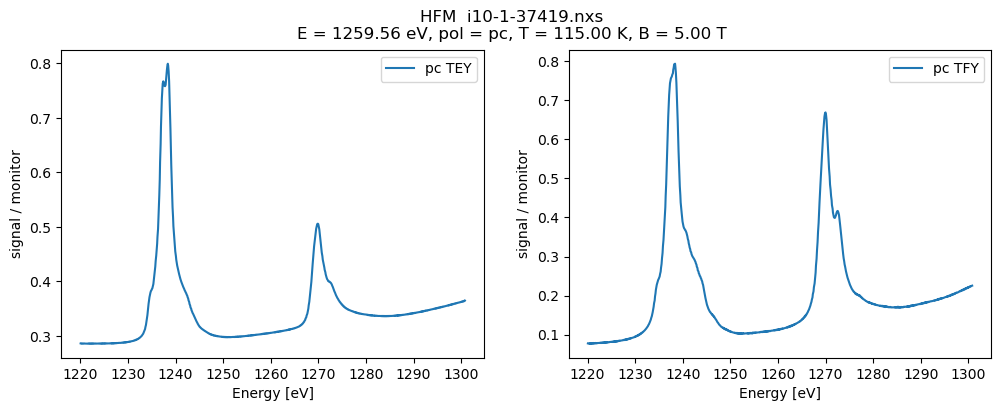

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(title)

ax[0].plot(energy, tey, '-', label=f"{metadata['pol']} TEY")
ax[1].plot(energy, tfy, '-', label=f"{metadata['pol']} TFY")

ax[0].set_xlabel('Energy [eV]')
ax[0].set_ylabel('signal / monitor')
ax[0].legend()

ax[1].set_xlabel('Energy [eV]')
ax[1].set_ylabel('signal / monitor')
ax[1].legend()

# Analyse absorption edge

1. normalise by pre-edge
2. fit step-edge background
3. remove background and normalise to step-edge
4. save NeXus file

In [6]:
# Get absorption edge from energy
from mmg_toolbox.spectra_analysis import energy_range_edge_label, xray_edges_in_range

print(f"Absorption edges between: {energy.min()}, {energy.max()} eV")
print('\n'.join(f"{en} eV : {lab}" for en, lab in xray_edges_in_range(energy.min(), energy.max(), search_edges=None)))

edge_label = energy_range_edge_label(energy.min(), energy.max())
print(f"\nEdge label: {' '.join(edge_label)}")

Absorption edges between: 1220.0712, 1300.7871 eV
Gd M4 eV : 1222.0
Pa N2 eV : 1224.0
Tb M5 eV : 1241.0
Pr M3 eV : 1242.0
Ge L2 eV : 1248.0
Ac N1 eV : 1269.0
Sg N2 eV : 1271.0
Pu N2 eV : 1271.0
Db N2 eV : 1271.0
Lv N2 eV : 1271.0
Mc N2 eV : 1271.0
Fl N2 eV : 1271.0
U N2 eV : 1271.0
No N2 eV : 1271.0
Md N2 eV : 1271.0
Ts N2 eV : 1271.0
Og N2 eV : 1271.0
Am N2 eV : 1271.0
Bh N2 eV : 1271.0
Hs N2 eV : 1271.0
Fm N2 eV : 1271.0
Lr N2 eV : 1271.0
Bk N2 eV : 1271.0
Cm N2 eV : 1271.0
Rf N2 eV : 1271.0
Cf N2 eV : 1271.0
Es N2 eV : 1271.0
Np N2 eV : 1271.0
Mt N2 eV : 1271.0
Rg N2 eV : 1271.0
Cn N2 eV : 1271.0
Nh N2 eV : 1271.0
Ds N2 eV : 1271.0
Ce M2 eV : 1274.0
Tb M4 eV : 1277.0
Dy M5 eV : 1293.0
Ba M1 eV : 1293.0
Nd M3 eV : 1297.0
Ga L1 eV : 1299.0

Edge label: Ge L2


In [7]:
# Load scan as Spectra object
from mmg_toolbox.nxxas_loader import load_from_nxs_using_hdfmap
scan = load_from_nxs_using_hdfmap(inpath)
print(scan)

/dls/i10-1/data/2025/cm40624-3//i10-1-37419.nxs
2025-06-21 00:33:11.428000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.56 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cr'


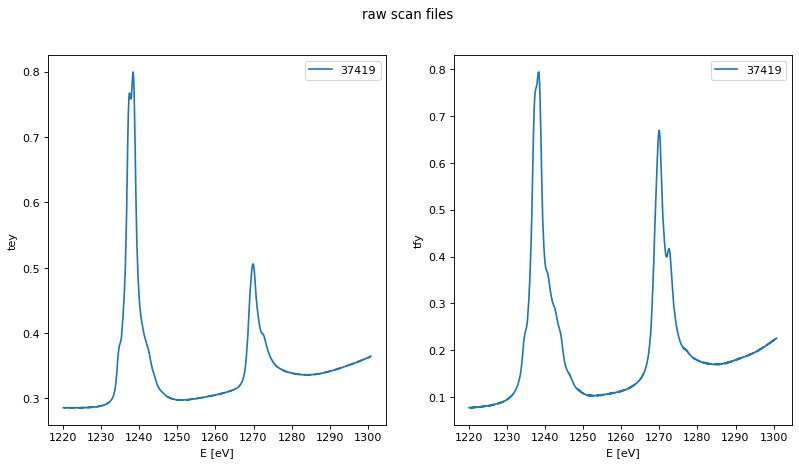

In [8]:
# Plot raw spectra
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
fig.suptitle('raw scan files')
for n, (mode, spectra) in enumerate(scan.spectra.items()):
    spectra.plot(ax=axes[n], label=scan.name)
    axes[n].set_ylabel(mode)

for ax in axes.flat:
    ax.set_xlabel('E [eV]')
    ax.legend()

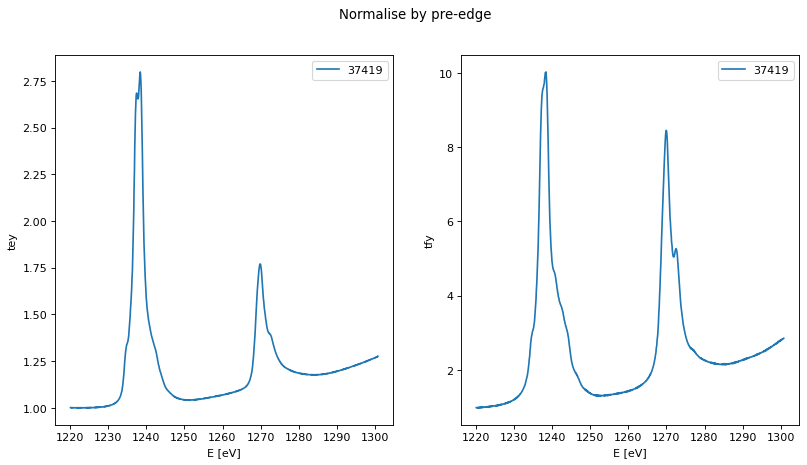

In [9]:
# 1. Normalise by pre-edge
scan.divide_by_preedge()

# plot scan normalised scan files
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
fig.suptitle('Normalise by pre-edge')
for n, (mode, spectra) in enumerate(scan.spectra.items()):
    spectra.plot(ax=axes[n], label=scan.name)
    axes[n].set_ylabel(mode)

for ax in axes.flat:
    ax.set_xlabel('E [eV]')
    ax.legend()


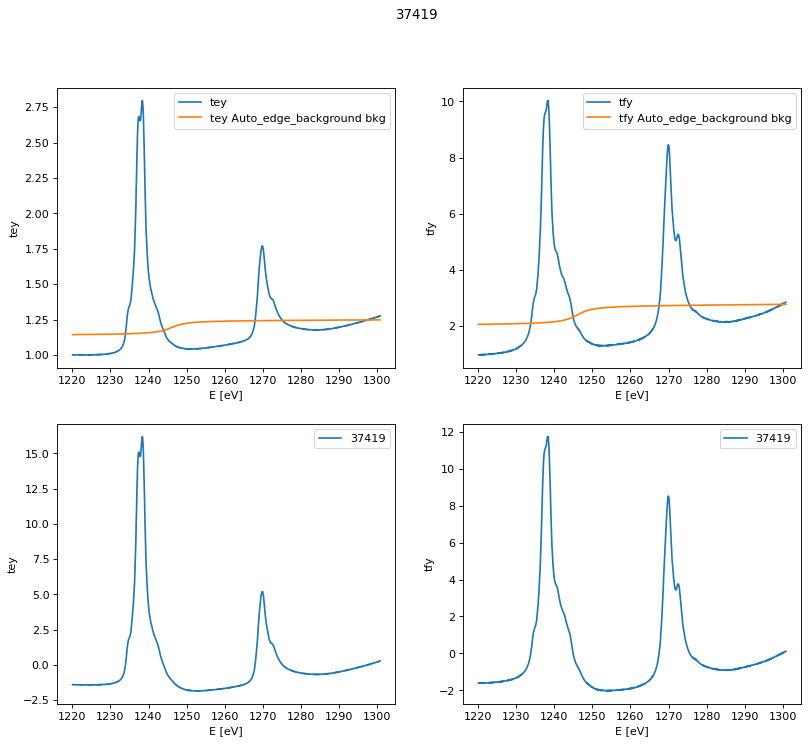

In [10]:
# 2. Fit and subtract background
scan.auto_edge_background(peak_width_ev=10.)

# Plot background subtracted scans
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=80)
fig.suptitle(scan.name)
for n, (mode, spectra) in enumerate(scan.spectra.items()):
    spectra.plot_parents(ax=axes[0, n])
    spectra.plot_bkg(ax=axes[0, n])
    axes[0, n].set_ylabel(mode)

    spectra.plot(ax=axes[1, n], label=scan.name)
    axes[1, n].set_ylabel(mode)

for ax in axes.flat:
    ax.set_xlabel('E [eV]')
    ax.legend()

In [11]:
# 4. Save Nexus file
#scan.write_nexus(outpath)

# Search for previous NXxas scans
If the previous scan was also a spectra scan, plot this and take the difference

In [12]:
from mmg_toolbox.nxxas_loader import find_similar_measurements

# check previous ~10 scans and build a list of energy scans at the same edge, temperature and field
# see help(find_similar_measurements) for more info
scans = find_similar_measurements(inpath)
pols = {s.metadata.pol for s in scans}

print(f"Unique polarisations: {pols}")

if len(pols) > 1:
    print('\n\n'.join(str(s) for s in scans))
else:
    print('Not enough polarisations')

Unique polarisations: {'cl', 'cr'}
/dls/i10-1/data/2025/cm40624-3/i10-1-37412.nxs
2025-06-21 00:10:34.016000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.87 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cr'

/dls/i10-1/data/2025/cm40624-3/i10-1-37413.nxs
2025-06-21 00:13:26.225000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.94 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cl'

/dls/i10-1/data/2025/cm40624-3/i10-1-37414.nxs
2025-06-21 00:16:02.591000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.83 eV -> Ge L2
   Sample: ''
T = 114.99 K
B = 5.00 T
Pol = 'cl'

/dls/i10-1/data/2025/cm40624-3/i10-1-37415.nxs
2025-06-21 00:20:16.191000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E =

/dls/i10-1/data/2025/cm40624-3/i10-1-37412.nxs
2025-06-21 00:10:34.016000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.87 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cr'
/dls/i10-1/data/2025/cm40624-3/i10-1-37413.nxs
2025-06-21 00:13:26.225000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.94 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cl'
/dls/i10-1/data/2025/cm40624-3/i10-1-37414.nxs
2025-06-21 00:16:02.591000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.83 eV -> Ge L2
   Sample: ''
T = 114.99 K
B = 5.00 T
Pol = 'cl'
/dls/i10-1/data/2025/cm40624-3/i10-1-37415.nxs
2025-06-21 00:20:16.191000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.83 eV -> Ge L2
   Sample: ''
T =

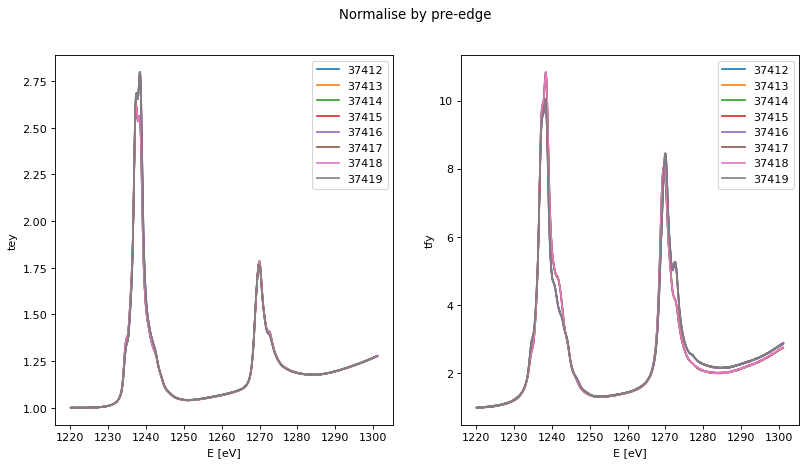

In [13]:
# Repeat steps 1-3 for each scan
if len(pols) > 1:
    for scan in scans:
        scan.divide_by_preedge()
        print(scan)

    # plot scan normalised scan files
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
    fig.suptitle('Normalise by pre-edge')
    for scan in scans:
        for n, (mode, spectra) in enumerate(scan.spectra.items()):
            spectra.plot(ax=axes[n], label=scan.name)
            axes[n].set_ylabel(mode)

    for ax in axes.flat:
        ax.set_xlabel('E [eV]')
        ax.legend()
else:
    print('Not enough polarisations')


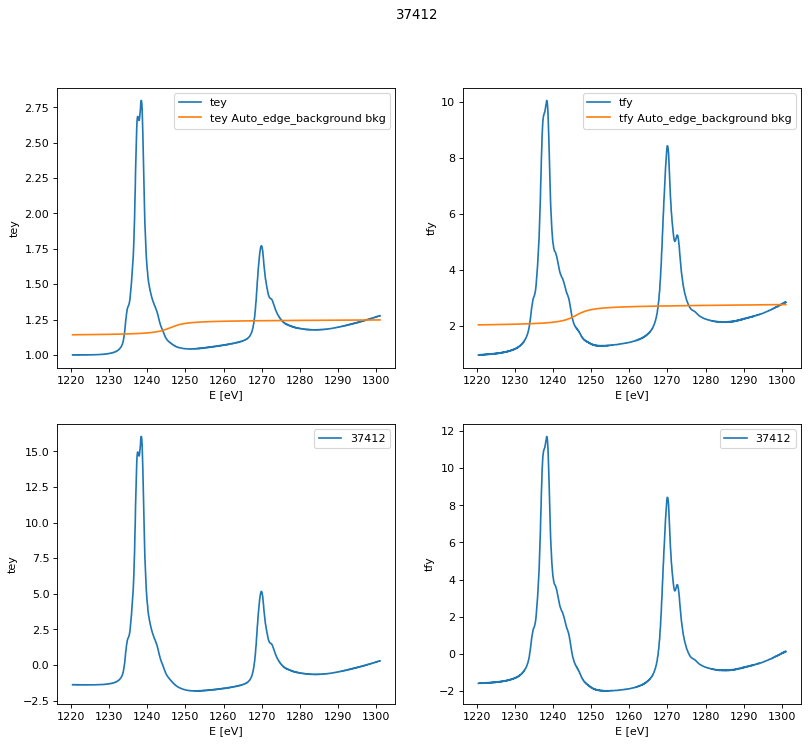

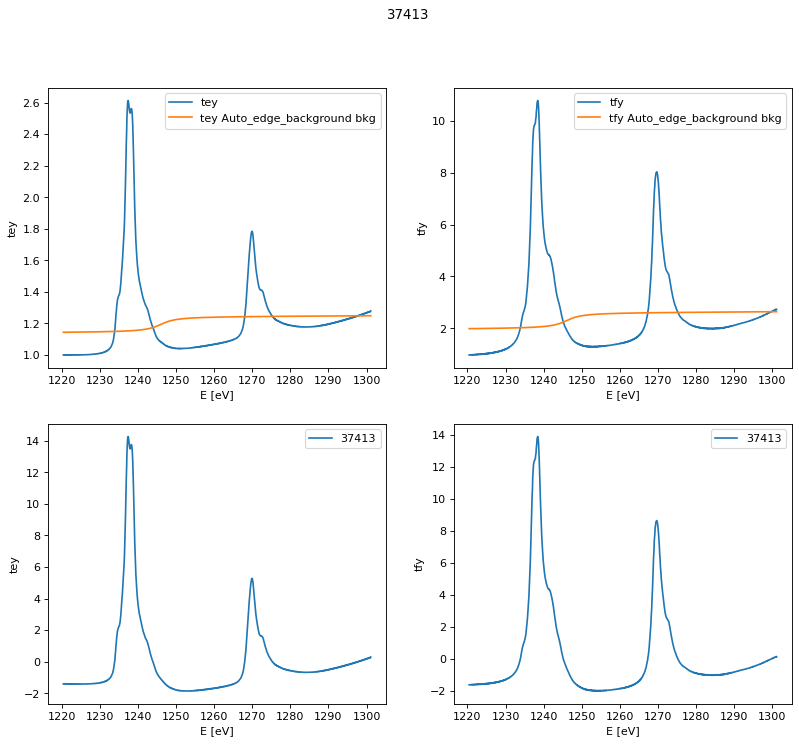

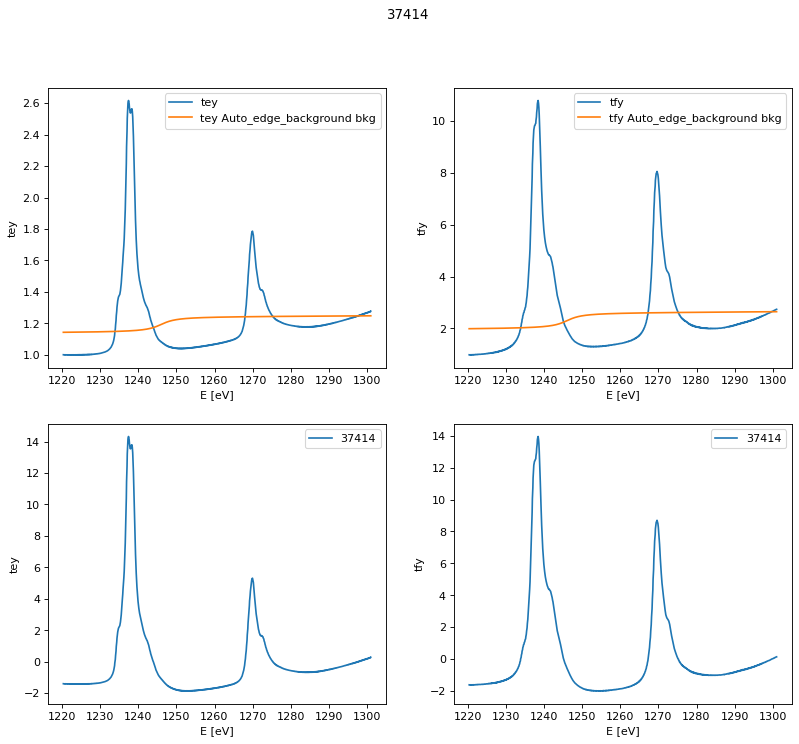

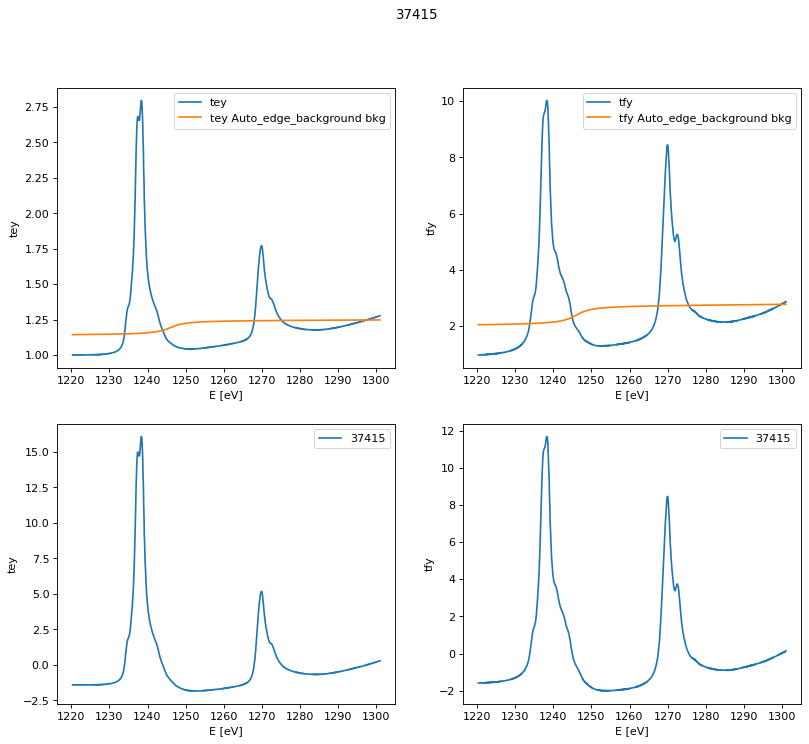

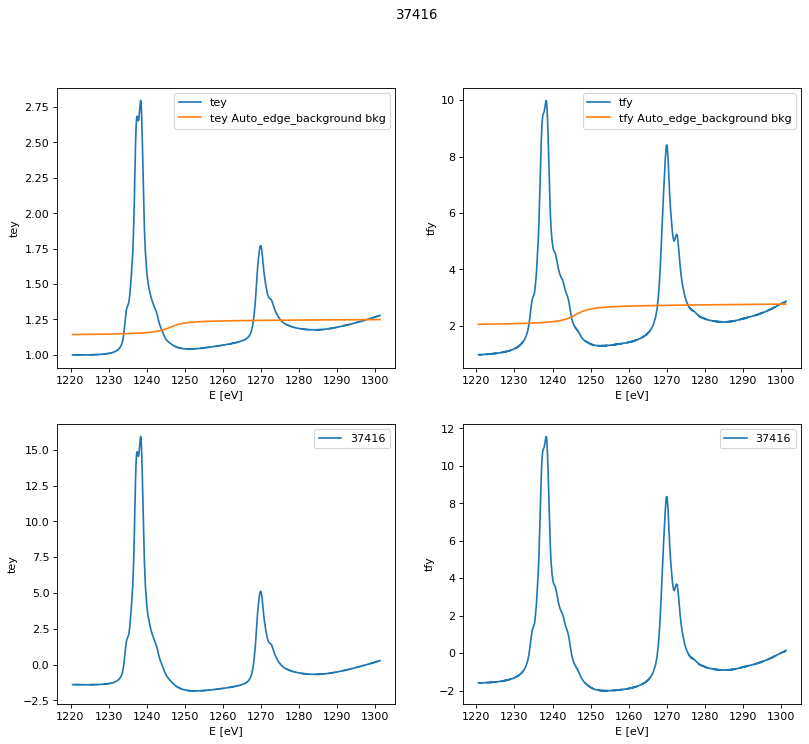

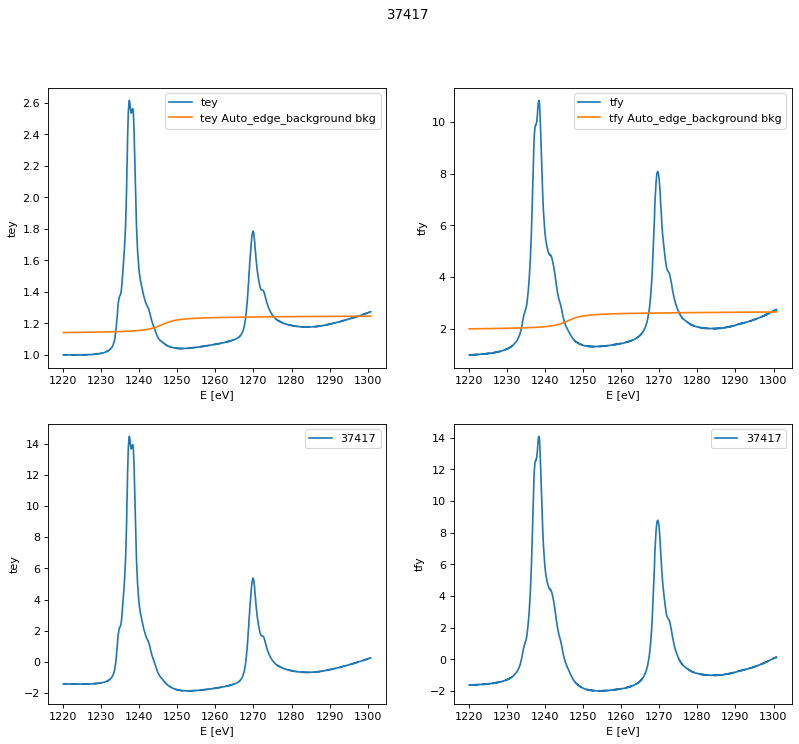

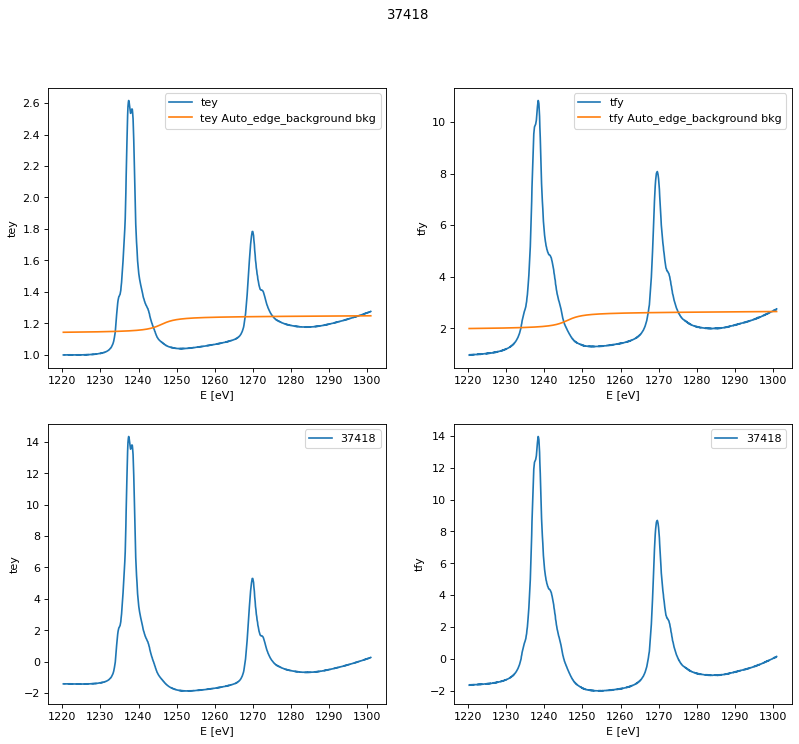

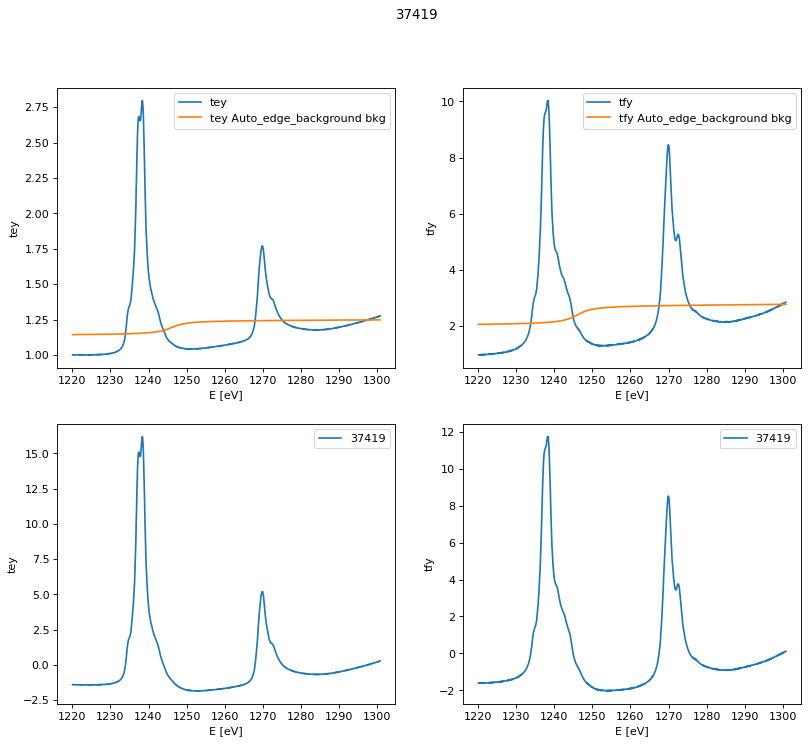

In [14]:
# Fit and subtract background
if len(pols) > 1:
    for scan in scans:
        scan.auto_edge_background(peak_width_ev=10.)

    # Plot background subtracted scans
    for scan in scans:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=80)
        fig.suptitle(scan.name)
        for n, (mode, spectra) in enumerate(scan.spectra.items()):
            spectra.plot_parents(ax=axes[0, n])
            spectra.plot_bkg(ax=axes[0, n])
            axes[0, n].set_ylabel(mode)

            spectra.plot(ax=axes[1, n], label=scan.name)
            axes[1, n].set_ylabel(mode)

        for ax in axes.flat:
            ax.set_xlabel('E [eV]')
            ax.legend()


37412: cr
37413: cl
37414: cl
37415: cr
37416: cr
37417: cl
37418: cl
37419: cr
/dls/i10-1/data/2025/cm40624-3/i10-1-37413.nxs
2025-06-21 00:13:26.225000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.94 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cl'
/dls/i10-1/data/2025/cm40624-3/i10-1-37412.nxs
2025-06-21 00:10:34.016000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.87 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cr'


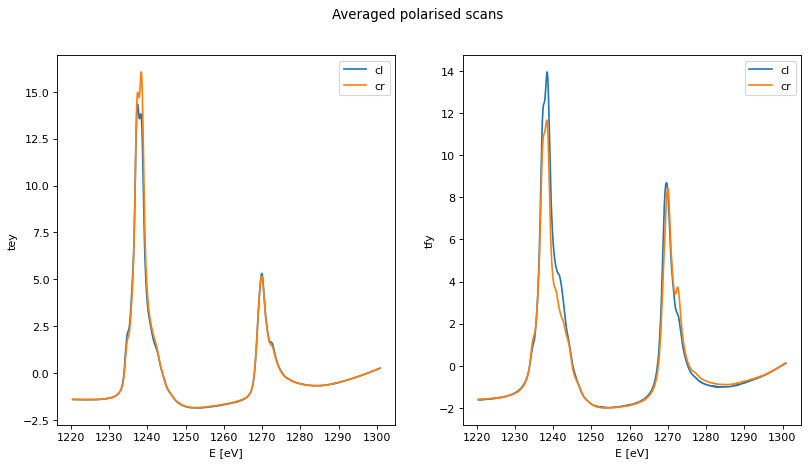

In [15]:
if len(pols) > 1:
    from mmg_toolbox.spectra_container import average_polarised_scans

    # Average polarised scans
    for scan in scans:
        print(f"{scan.name}: {scan.metadata.pol}")
    pol1, pol2 = average_polarised_scans(*scans)
    print(pol1)
    print(pol2)

    # Plot averaged scans
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
    fig.suptitle('Averaged polarised scans')
    for scan in [pol1, pol2]:
        for n, (mode, spectra) in enumerate(scan.spectra.items()):
            spectra.plot(ax=axes[n], label=scan.name)
            axes[n].set_ylabel(mode)

    for ax in axes.flat:
        ax.set_xlabel('E [eV]')
        ax.legend()


# Calculate XMCD/XMLD

In [16]:
if len(pols) > 1:
    # Calculate XMCD
    xmcd = pol1 - pol2
    print(xmcd)

    for name, spectra in xmcd.spectra.items():
        print(spectra)
        print(spectra.process)
        print(spectra.sum_rules_report(1))



2025-06-21 00:13:26.225000
scan energy 1220 1300 0.1 mcsh16 0.15 mcsh17 0.15 mcsh18 0.15 mcsh19 0.15
mode: 'tey', signals: ['tey', 'tfy']
E = 1259.94 eV -> Ge L2
   Sample: ''
T = 115.00 K
B = 5.00 T
Pol = 'cl'
SpectraSubtraction('tey', energy=array(1649,), signal=array(1649,),process_label='subtraction')
Subtraction of spectra S1 - S2:
  S1: SpectraAverage('tey', energy=array(1603,), signal=array(1603,),process_label='average_cl')
  S2: SpectraAverage('tey', energy=array(1649,), signal=array(1649,),process_label='average_cr')
 n_holes = 1
L = 1.697 μB
S = 2.871 μB
SpectraSubtraction('tfy', energy=array(1649,), signal=array(1649,),process_label='subtraction')
Subtraction of spectra S1 - S2:
  S1: SpectraAverage('tfy', energy=array(1603,), signal=array(1603,),process_label='average_cl')
  S2: SpectraAverage('tfy', energy=array(1649,), signal=array(1649,),process_label='average_cr')
 n_holes = 1
L = -1.748 μB
S = -3.391 μB


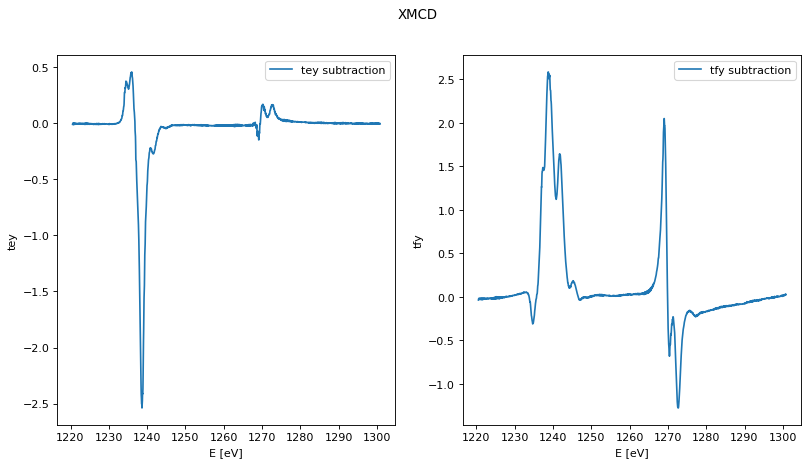

In [17]:
if len(pols) > 1:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
    fig.suptitle(xmcd.name.upper())
    for n, (mode, spectra) in enumerate(xmcd.spectra.items()):
        spectra.plot(ax=axes[n])
        axes[n].set_ylabel(mode)

    for ax in axes.flat:
        ax.set_xlabel('E [eV]')
        ax.legend()

In [18]:
if len(pols) > 1:
    # Save xmcd file
    xmcd_filename = f"{scans[0].metadata.scan_no}-{scans[-1].metadata.scan_no}_{xmcd.name}.nxs"
    output_folder = os.path.dirname(outpath)
    #xmcd.write_nexus(os.path.join(output_folder, xmcd_filename))